Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\glass\086_00411_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=6
Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\metal\052_01211_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=5
Error with C:/Users/andre/Desktop/UrbanMining/SortedMaterials\metal\073_00211_knock_07.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=5

FOLD 1
Test Accuracy: 60.17%
Train Accuracy: 100.00%

FOLD 2
Test Accuracy: 62.18%
Train Accuracy: 100.00%

FOLD 3
Test Accuracy: 56.41%
Train Accuracy: 100.00%

FOLD 4
Test Accuracy: 74.36%
Train Accuracy: 100.00%

FOLD 5
Test Accuracy: 70.94%
Train Accuracy: 100.00%


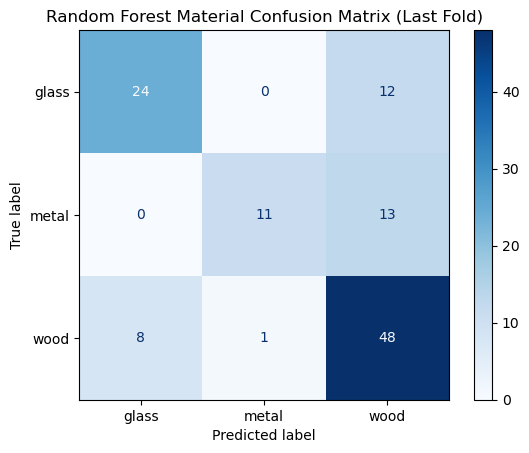


Mean CV Accuracy: 64.81%


In [ ]:
# STEP 1: Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import re
import noisereduce as nr

# STEP 2: Define Paths
base_dir = r"Insert sorted materal path"  # organized by wood/metal/glass
sr = 22050  # sample rate

# STEP 3: Feature Extraction Function
def extract_features(file_path):
    y, _ = librosa.load(file_path, sr=sr)
    y = y.astype(np.float32)

    # MFCCs and their deltas
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Spectral features
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    onset = librosa.onset.onset_strength(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)

    # Aggregate features
    features = np.hstack([
        np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
        np.mean(mfcc_delta, axis=1), np.std(mfcc_delta, axis=1),
        np.mean(mfcc_delta2, axis=1), np.std(mfcc_delta2, axis=1),
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(onset), np.std(onset),
        np.mean(zcr), np.std(zcr),
        np.mean(rms), np.std(rms),
        np.mean(contrast, axis=1), np.std(contrast, axis=1)
    ])

    return features

# STEP 4: Load Data
X, y, groups = [], [], []

door_to_group = {}
group_counter = 0

for label in ["glass", "metal", "wood"]:
    path = os.path.join(base_dir, label)
    for wav_file in glob(os.path.join(path, "*.wav")):
        try:
            # Feature extraction
            features = extract_features(wav_file)
            X.append(features)
            y.append(label)

            # Grouping: extract door ID (e.g., 009_10411)
            fname = os.path.basename(wav_file)
            match = re.match(r'^(\d+_\d+)', fname)
            if not match:
                raise ValueError(f"Could not extract door ID from: {fname}")
            door_id = match.group(1)

            if door_id not in door_to_group:
                door_to_group[door_id] = group_counter
                group_counter += 1

            groups.append(door_to_group[door_id])
        except Exception as e:
            print(f"Error with {wav_file}: {e}")

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

# STEP 5: GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
fold = 1
accuracies = []

for train_idx, test_idx in gkf.split(X, y, groups):
    print(f"\nFOLD {fold}")
    fold += 1
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, max_depth=7, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    train_acc = clf.score(X_train, y_train)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print(f"Train Accuracy: {train_acc * 100:.2f}%")
    accuracies.append(acc)

# STEP 6: Final Evaluation (Optional - on last fold only)
labels_order = ["glass", "metal", "wood"]
cm = confusion_matrix(y_test, y_pred, labels=labels_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest Material Confusion Matrix (Last Fold)")
plt.show()

# STEP 7: Print Mean Accuracy
print(f"\nMean CV Accuracy: {np.mean(accuracies) * 100:.2f}%")


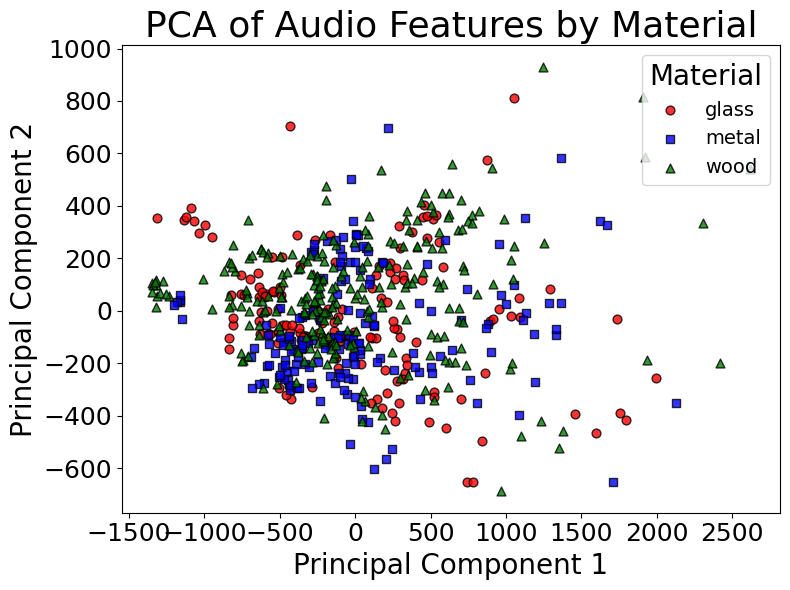

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# === Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# === Make DataFrame for plotting
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Material': y
})

# === Define shape and color for each material
material_styles = {
    'glass': {'color': 'red',    'marker': 'o'},  # circle
    'metal': {'color': 'blue',   'marker': 's'},  # square
    'wood':  {'color': 'green',  'marker': '^'}   # triangle
}

# === Plot
plt.figure(figsize=(8, 6))
for material, style in material_styles.items():
    subset = df_pca[df_pca['Material'] == material]
    plt.scatter(
        subset['PC1'], subset['PC2'],
        label=material,
        c=style['color'],
        marker=style['marker'],
        edgecolors='black',
        alpha=0.8,
        s=40
    )

plt.title("PCA of Audio Features by Material", fontsize=26)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Material', fontsize=14, title_fontsize=20, loc='upper right')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [5, 7, 8, 9, 10, 20, 30, None]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X, y)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [5, 7, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


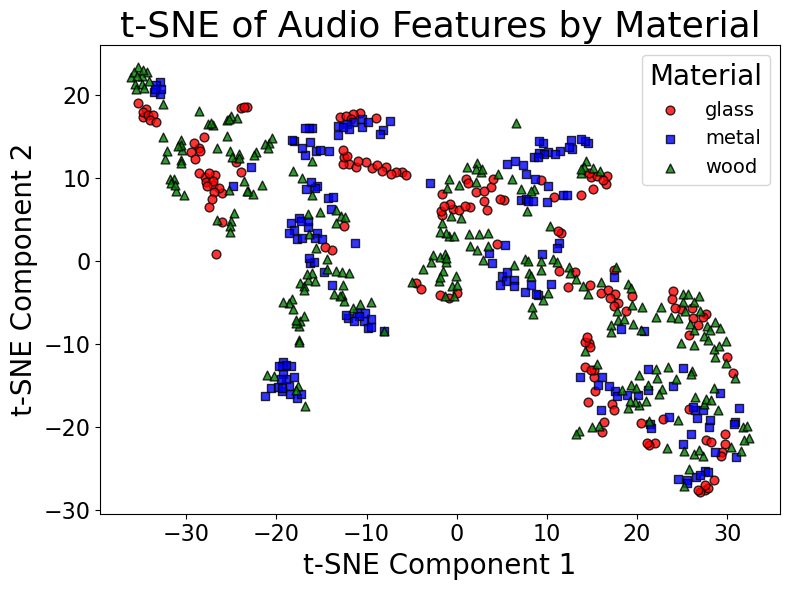

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# === Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

# === Prepare DataFrame
df_tsne = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'Material': y
})

# === Define shape and color for each material
material_styles = {
    'glass': {'color': 'red',    'marker': 'o'},  # circle
    'metal': {'color': 'blue',   'marker': 's'},  # square
    'wood':  {'color': 'green',  'marker': '^'}   # triangle
}

# === Plot
plt.figure(figsize=(8, 6))
for material, style in material_styles.items():
    subset = df_tsne[df_tsne['Material'] == material]
    plt.scatter(
        subset['TSNE-1'], subset['TSNE-2'],
        label=material,
        c=style['color'],
        marker=style['marker'],
        edgecolors='black',
        alpha=0.8,
        s=40
    )

plt.title("t-SNE of Audio Features by Material", fontsize=26)
plt.xlabel("t-SNE Component 1", fontsize=20)
plt.ylabel("t-SNE Component 2", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Material', fontsize=14, title_fontsize=20, loc='upper right')
plt.tight_layout()
plt.show()
